In [1]:
import sys
import pandas as pd
import numpy as np
import re
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from pprint import pprint


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score,accuracy_score,precision_recall_curve,confusion_matrix,make_scorer
from sklearn.metrics import roc_auc_score, roc_curve

from src.models.model_utilities import choose_features,prepare_model_data,tv_split,prepare_rf_random_search_grid, rf_random_search

# NBA Daily Fantasy Analysis and Predictions


## Introduction

 Daily fantasy sports have become a popular pastime recently. Player compete against one another to create the best team, constrained by salary and positions, to win prizes. Can we predict NBA player fantasy points to find misvalued players?

## Data Preparation

Significant data prepration went into creating the final data frames for analysis and modeling, including multiple transformations, moving averages, and merges to combine player with salary data. Please see [here](https://github.com/pdekhman/nba_dfs_value/blob/master/src/main_data_prep.py) for top-level data prep code and lower level function imports

## Exploratory Data Analysis

In [2]:
#read in procesed data file
processed_data_dir = '~/nba_dfs_value/data/processed/'
df = pd.read_pickle(processed_data_dir+"full.pkl")

### Distribution of Target Variable

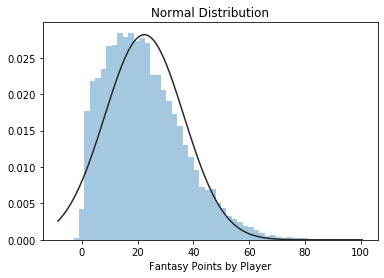

In [3]:
sns.distplot(df.fp,kde=False,fit=st.norm)
plt.title('Normal Distribution')
plt.xlabel('Fantasy Points by Player')
plt.show()

The distribution of fantasy points is not normal, keep that in mind when we begin modeling

### Distributions of Categorical Variables

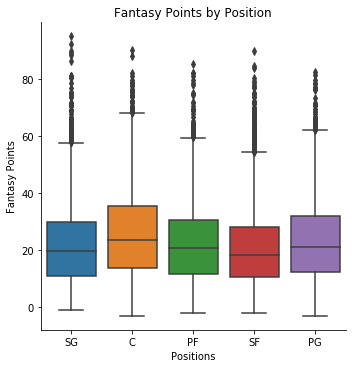

In [4]:
sns.catplot(x="pos", y="fp", kind="box", data=df)
plt.title("Fantasy Points by Position")
plt.xlabel('Positions')
plt.ylabel("Fantasy Points")
plt.show()

Fantasy point distributions vary between positions, with centers having the largest median fantasy points and small forwards the least

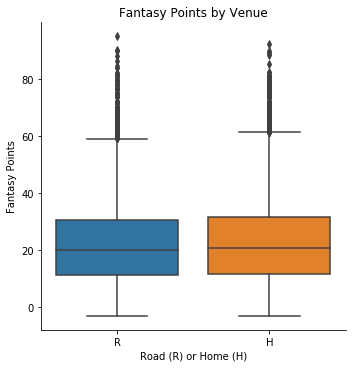

In [5]:
sns.catplot(x="venue", y="fp", kind="box", data=df)
plt.title("Fantasy Points by Venue")
plt.xlabel('Road (R) or Home (H)')
plt.ylabel("Fantasy Points")
plt.show()

The distribution of fantasy points by venue (road or home) are similar

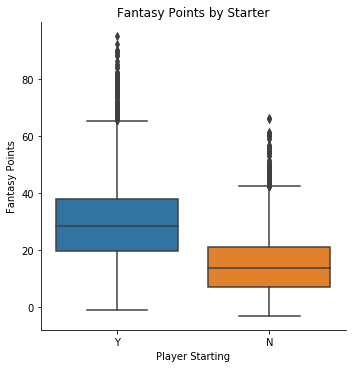

In [6]:
sns.catplot(x="start", y="fp", kind="box", data=df)
plt.title("Fantasy Points by Starter")
plt.xlabel("Player Starting")
plt.ylabel("Fantasy Points")
plt.show()

As expected, starters score more fantasy points

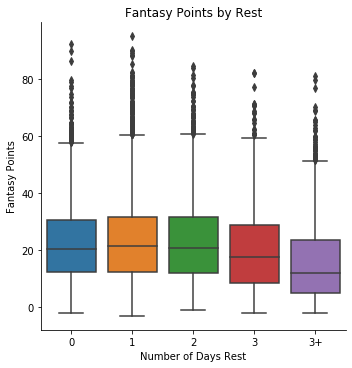

In [7]:
sns.catplot(x="rest", y="fp", kind="box", data=df)
plt.title("Fantasy Points by Rest")
plt.xlabel("Number of Days Rest")
plt.ylabel("Fantasy Points")
plt.show()

Surprisingly, more rest doesn't seem to be correlated with higher fantasy points. Could longer rest times leave players rusty?

### Distributions of Continous Variables

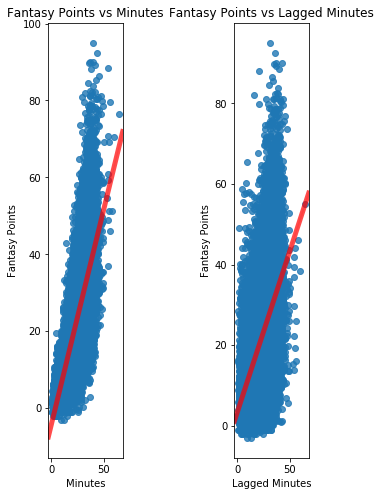

In [8]:
fig = plt.figure(figsize=(8,8))

plt.subplot(1,3,1)
sns.regplot(x='min',y='fp',line_kws={"color":"r","alpha":0.7,"lw":5},data=df)
plt.title('Fantasy Points vs Minutes')
plt.ylabel("Fantasy Points")
plt.xlabel("Minutes")

plt.subplot(1,3,2)
sns.regplot(x='min_lag',y='fp',line_kws={"color":"r","alpha":0.7,"lw":5},data=df)
plt.title('Fantasy Points vs Lagged Minutes')
plt.ylabel("Fantasy Points")
plt.xlabel("Lagged Minutes")

plt.subplots_adjust(wspace=1.5)
plt.show()

Minutes govern how much opportunity a player has to produce fantasy statistics. Since we are predicting fantasy points we must use lagged values of minutes (in various transformations), which still have a strong positive correlation with fantasy points, but less so then concurrent minutes

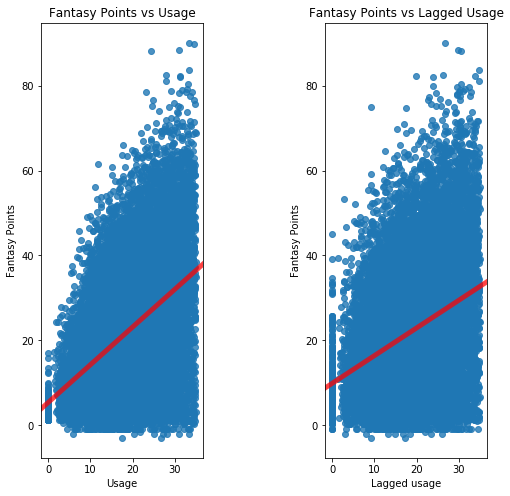

In [9]:
fig = plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
sns.regplot(x='usage',y='fp',line_kws={"color":"r","alpha":0.7,"lw":5},data=df[df.usage<=35])
plt.title('Fantasy Points vs Usage')
plt.ylabel("Fantasy Points")
plt.xlabel("Usage")
#plt.ylim((0,35))

plt.subplot(1,2,2)
sns.regplot(x='usage_lag',y='fp',line_kws={"color":"r","alpha":0.7,"lw":5},data=df[df.usage_lag<=35])
plt.title('Fantasy Points vs Lagged Usage')
plt.ylabel("Fantasy Points")
plt.xlabel("Lagged usage")


plt.subplots_adjust(wspace=0.75)
plt.show()

A players "usage" roughly translates to his level of involvement while he is on the floor, and also correlates strongly with fantasy points. Likewise, one game lagged usage is also strongly correlated to fantasy points

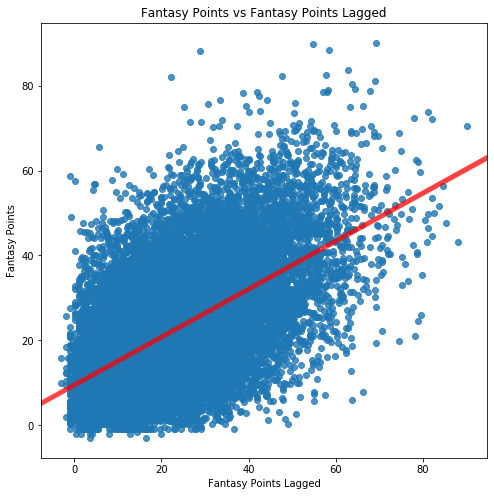

In [10]:
fig = plt.figure(figsize=(8,8))

sns.regplot(x='fp_lag',y='fp',line_kws={"color":"r","alpha":0.7,"lw":5},data=df[df.usage<=35])
plt.title('Fantasy Points vs Fantasy Points Lagged')
plt.ylabel("Fantasy Points")
plt.xlabel("Fantasy Points Lagged")

plt.show()

Finally, lagged fantasy points are themselves one of the best predictors 

In [11]:
df_corr = df[['fp','min','usage','fp_lag','min_lag','usage_lag']]
corr_matrix = df_corr.corr()
corr_matrix

,fp,min,usage,fp_lag,min_lag,usage_lag
fp,1.000000,0.761523,0.450766,0.597385,0.541916,0.335836
min,0.761523,1.000000,0.198785,0.562330,0.696116,0.216044
usage,0.450766,0.198785,1.000000,0.330569,0.206425,0.435215
fp_lag,0.597385,0.562330,0.330569,1.000000,0.761197,0.452056
min_lag,0.541916,0.696116,0.206425,0.761197,1.000000,0.199658
usage_lag,0.335836,0.216044,0.435215,0.452056,0.199658,1.000000


In conclusion, the variables in the below correlation matrix should be sufficient to build a predictive baseline for fantasy points

## Modeling

### Baseline Linear Model

We will begin our modeling approach with a simple linear regession model  to serve as a baseline. Please see [model_utilities.py](https://github.com/pdekhman/nba_dfs_value/blob/master/src/models/model_utilities.py) for details on user defined functions.

In [12]:
#Prepare feature set and target set
model_df = df[['pos','venue','start','rest','fp_lag','min_lag','usage_lag','fp']].copy()
dummies = ['pos','venue','start','rest']
target = 'fp'
X, y, model_columns = prepare_model_data(model_df,target)

#split into training and test sets
X_train,X_ho,y_train,y_ho = tv_split(X,y,test=.2)

#create temporal time series train/validations sets to preserve timeseries
tscv = TimeSeriesSplit(n_splits=5)

#fit and get average of cross validated RMSE's
reg = LinearRegression().fit(X_train,y_train)
print("Averge RMSE: {:6.1f} ".format(np.sqrt(np.mean(cross_val_score(reg, X_train, y_train, cv=tscv,scoring='neg_mean_squared_error'))*-1)))
pd.DataFrame(list(zip(model_columns,reg.coef_)),columns=['coefficient','coefficient_value'])



Averge RMSE:   10.6 


,coefficient,coefficient_value
0,fp_lag,0.300928
1,min_lag,0.197305
2,usage_lag,0.229994
3,pos_C,2.004472
4,pos_PF,0.104221
5,pos_PG,-0.055669
6,pos_SF,-0.930344
7,pos_SG,-1.122680
8,venue_H,0.375395
9,venue_R,-0.375395


Looking at the above, the average RMSE for our simple linear model is 10.6 (we miss each prediction by an average of 10.6 fantasy points).

The regression coefficients for the full training set prove our simple visualizations.

### Baseline Random Forest

Next we will try a tree-based method, to see if we can do better.

In [13]:
rf = RandomForestRegressor(n_estimators = 500,max_features='sqrt', min_samples_leaf=5,max_depth = 6,n_jobs=-1)
print("Averge RMSE: {:6.1f} ".format(np.sqrt(np.mean(cross_val_score(rf, X_train, y_train, cv=tscv,scoring='neg_mean_squared_error'))*-1)))


Averge RMSE:   10.5 


The random forest model doesnt do much better at an average RMSE of only 10.5, barely better than the linear regression

### Random Forest with  RandomSearch Hyperparamter Tuning

I'll now try to more rigorously choose the the hyper parameters for the random forest using Random Search.

In [14]:
#prepare and print the random search grid
random_search_grid = prepare_rf_random_search_grid()

# run random search with cross validation to find the best hypera parameters for the random forest
params, best_score, best_rf = rf_random_search(X_train,y_train,random_search_grid,tscv,prob="R")

#run best model to get RMSE
rf = RandomForestRegressor(n_estimators = 500,max_features='sqrt', min_samples_leaf=5,max_depth = 6,n_jobs=-1)
print("Averge RMSE: {:6.1f} ".format(np.sqrt(np.mean(cross_val_score(best_rf, X_train, y_train, cv=tscv,scoring='neg_mean_squared_error'))*-1)))

{'max_depth': [4, 5, 6, 7, 8],
 'max_features': ['auto', 'sqrt', 0.6, 0.8],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 300, 500]}
Averge RMSE:   10.4 


Using hyper paramter tuning for the random forest, we only inch lower to an RMSE of 10.4

### Random Forest with Recursive Feature Selection and RandomSearch Hyperparamter Tuning

Lastly, well also try applying Recursive Feature Selection to our entire feature set to choose the best features, before tuning the Random Forest

In [15]:
target = 'fp'
unused_features = ['index','dataset','game_id','date','player_id','name','team','opp','fpd','last_start','pos',
                'last_start_lag', 'new_start_lag']
non_lag_features = ['rest','venue','start','salary','new_start','player_type_lag','def_type_lag','fp']
recursive_features = choose_features(df,target,unused_features,non_lag_features,verbose=False,corr=.2,prob ="R")


dummies = ['player_type_lag','venue','start','new_start','def_type_lag','rest','value_lag']
X, y, model_columns = prepare_model_data(df,target,features=recursive_features,dummies=dummies)

In [16]:
X_train,X_ho,y_train,y_ho = tv_split(X,y,test=.2)

tscv = TimeSeriesSplit(n_splits=5)

random_search_grid = prepare_rf_random_search_grid()

params, best_score, best_rf = rf_random_search(X_train,y_train,random_search_grid,tscv,verbose=1,prob="R")

rf = RandomForestRegressor(n_estimators = 500,max_features='sqrt', min_samples_leaf=5,max_depth = 6,n_jobs=-1)

print("Averge RMSE: {:6.1f} ".format(np.sqrt(np.mean(cross_val_score(best_rf, X_train, y_train, cv=tscv,scoring='neg_mean_squared_error'))*-1)))

{'max_depth': [4, 5, 6, 7, 8],
 'max_features': ['auto', 'sqrt', 0.6, 0.8],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 300, 500]}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished


Averge RMSE:    9.5 


Using recursive feature selection along with hyper paramter tuning gave a nice decrease in the RMSE to 9.5